In [1]:
 # These two lines are necessary only if GemPy is not installed
import sys, os
sys.path.append("../../..")

# Importing GemPy
import gempy as gp

# Embedding matplotlib figures in the notebooks
%matplotlib inline

# Importing auxiliary libraries
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm

In [2]:
path_to_data = os.pardir+"/../data/input_data/jan_models/"

geo_data = gp.create_data([0,1000,0,1000,0,1000],resolution=[50,50,50], 
                        path_o = path_to_data + "model1_orientations.csv",
                        path_i = path_to_data + "model1_surface_points.csv") 

Active grids: ['regular']


../../../gempy/core/model.py:793: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  self.surfaces.df['series'].cat.reorder_categories(self.series.df.index.get_values(),
../../../gempy/core/model.py:795: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  self.series.df.index = self.series.df.index.reorder_categories(self.series.df.index.get_values(),
../../../gempy/core/model.py:506: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  aux = self.series.df.index.drop('Basement').get_values()
../../../gempy/core/model.py:294: FutureWarning: The 'get_values' method is deprecated and will be removed in a future version. Use '.to_numpy()' or '.array' instead.
  self.surfaces.df['series'].cat.reorder_categories(self.series.df.index.get_values(),

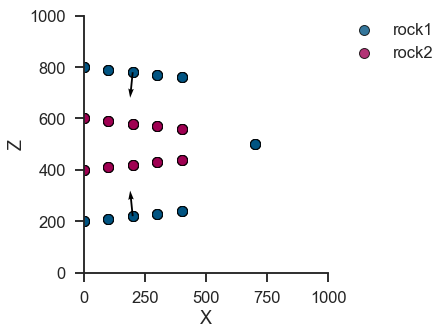

In [3]:
gp.plot.plot_data(geo_data)

We are going to make a likelihood function depending on the thickness of rock1 and 2. The most computing friendly way to do so is by adding the thickness as an attribute of the surfaces:

In [4]:
# This is the thickness of voxel
dz = geo_data.grid.regular_grid.dz
dz

20.0

In [5]:
geo_data.surfaces.add_surfaces_values([0, dz, 0], ['dz'])

KeyboardInterrupt: 

Now we can set the interpolator without compile theano. This will only create the graph:

In [ ]:
gp.set_interpolation_data(geo_data, theano_optimizer='fast_run',
                          compile_theano=False, gradient=True)

## Compiling gempy with PyMC3

Next we need to compute a theano Op from the gempy graph:

In [ ]:
import theano
import theano.tensor as T
theano.config.compute_test_value = 'ignore'

In [ ]:
geo_model_T = theano.OpFromGraph(geo_data.interpolator.theano_graph.input_parameters_loop,
                               [geo_data.interpolator.theano_graph.compute_series()[0][1][0:125000]], inline=True,
                                 on_unused_input='ignore',
                                 name='geo_model')

In [ ]:
import theano
import theano.tensor as tt
theano.config.compute_test_value = 'ignore'
# We convert a python variable to theano.shared
input_sh = []
i = geo_data.interpolator.get_python_input_block()
for ii in i:
    input_sh.append(theano.shared(ii))

# We get the rescaling parameters:
rf = geo_data.rescaling.df.loc['values', 'rescaling factor']
centers = geo_data.rescaling.df.loc['values', 'centers']

# We create pandas groups by id to be able to modify several points at the same time:
g = geo_data.surface_points.df.groupby('id')
l = theano.shared(np.array([], dtype='float32'))

In [ ]:
# PyMC3 model
theano.config.compute_test_value = 'ignore'

with pm.Model() as model:
    r2 = pm.Normal('rock2', 600, 50)
    r1 = pm.Normal('rock1', 400, 50)

    val2 = (r2 - centers[2]) / rf + 0.5001
    val1 = (r1 - centers[2]) / rf + 0.5001
    

    input_sh[4] = tt.set_subtensor(input_sh[4][g.groups[1], 2], val2)
    input_sh[4] = tt.set_subtensor(input_sh[4][g.groups[2], 2], val1)
    
    # we have to take the sol 0
    geo = geo_model_T(*input_sh)
    well = geo.reshape((50, 50, 50))[25,25,:]
   
    thickness = pm.Deterministic('thickness', well.sum())
    likelihood_function = pm.Normal('y', mu=thickness, sd=20, observed=120)

In [ ]:
with model:
    t = pm.load_trace('thickness_NUTS')
    t_metro = pm.load_trace('thickness_Metro')

In [ ]:
import gempy.bayesian.plot_posterior as pp
t_df =pm.trace_to_dataframe(t_metro)


In [ ]:
import importlib
importlib.reload(pp)

In [ ]:
joypy.joyplot?

In [ ]:
t_nuts_df =pm.trace_to_dataframe(t)


In [ ]:
importlib.reload(pp)
pp.plot_posterior(t_nuts_df, theta1_loc=600, theta1_scale=50,
                  theta2_loc=400, theta2_scale=50,
                  iteration=5,
                  model_mean_name='thickness', model_std=20.,
                  obs=120,
                  x_range=(75,200), sample_size=10000,
                  theta1_name='rock1', theta2_name='rock2', n_traces=101, yrot=70
              )


In [ ]:
def post_interact(iteration):
    pp.plot_posterior(t_nuts_df, theta1_loc=600, theta1_scale=50,
                  theta2_loc=400, theta2_scale=50,
                  iteration=iteration,
                  model_mean_name='thickness', model_std=20.,
               obs=120,
               x_range=(75,200), sample_size=100, n_traces=11,
                                        theta1_name='rock1', theta2_name='rock2'

              )


In [ ]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

interact(post_interact, iteration=(0, 1000, 1))

In [ ]:
np.arange(10)[8:2:-1]

In [ ]:
pm.traceplot(t)

In [ ]:
pm.traceplot(t_metro)

In [ ]:
from IPython.core.pylabtools import figsize
import numpy as np
figsize(12.5, 4)
import scipy.stats as stats

import matplotlib.pyplot as plt
from matplotlib import cm

# Create cmap
from matplotlib.colors import ListedColormap
import seaborn as sns
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
my_cmap = ListedColormap(pal)

# Seaborn style 
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})
# Data

r2_loc = 600
r2_scale = 50
r1_loc = 400
r1_scale = 50

# Prior space
rock2 = np.linspace(r2_loc-r2_scale*3, r2_loc+r2_scale*3, 500)
rock1 = np.linspace(r1_loc-r1_scale*3, r1_loc+r1_scale*3, 500)

# 2D prior space
X, Y = np.meshgrid(rock2, rock1)

# We set our normal distribution
nor_x = stats.norm.pdf(rock2, loc=r2_loc, scale=r2_scale) # Related to estandar deviation: more unknown in beta
nor_y = stats.norm.pdf(rock1, loc=r1_loc, scale=r1_scale) 

# Prior probability
M = np.dot(nor_x[:, None], nor_y[None, :])


# Contour plot:

figsize(12.5, 5)
fig = plt.figure()
plt.subplot(121)

M_ma = np.ma.masked_less_equal(M, 1e-6)
im = plt.imshow(M_ma, interpolation='gaussian',
                origin='lower', alpha=0.6,
     cmap=my_cmap,
     extent=(r2_loc-r2_scale*3, r2_loc+r2_scale*3, r1_loc-r1_scale*3, r1_loc+r1_scale*3)
               )

plt.xlabel("z rock2")
plt.ylabel("z rock1")
plt.title("Prior distribution landscape")
sns.despine(left=True, bottom=True)

# Plotting likelihood
thick_max = 200
thick_min = 50
thick_vals = np.linspace(thick_min, thick_max, 100)
observation = np.array([120])

thick_model = 100
thick_std = 20


# Making the axes:
# fig = plt.figure()

ax = fig.add_subplot(122)
ax.spines['bottom'].set_position(('data', 0.0))
ax.spines['left'].set_position(('data', thick_min-thick_min*.1))
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

nor_l = stats.norm.pdf(thick_vals, loc=thick_model, scale=thick_std) 


y_min = (nor_l.min()-nor_l.max())*.1
y_max =  nor_l.max()+ nor_l.max()*.05



plt.plot(thick_vals, nor_l, color = '#7eb1bc', linewidth=.5)
plt.fill_betweenx(nor_l, thick_vals, color= pal.as_hex()[4], alpha=.4)
plt.vlines(thick_model, 0, y_max, linestyles='dashdot')
plt.scatter(observation, np.zeros_like(observation), s=50, c='#DA8886')


plt.ylim(y_min, y_max)
plt.xlim(thick_min, thick_max)
plt.xlabel('Thickness Obs.')
plt.ylabel('Likelihood')
plt.title('Likelihood')

plt.tight_layout()


In [ ]:
# Joyplot
import joypy
import pandas as pd
import pandas as pn
import importlib
importlib.reload(joypy)
t_df =pm.trace_to_dataframe(t_metro)
a = t_df.loc[150:250:1]
b = a['thickness']
c = pd.DataFrame()
for e, i in a['thickness'].iteritems():
    print(e,i)
    num = np.random.normal(loc=i, scale=thick_std, size=100)
    name = str(e)
    c[name] = num

In [ ]:
a['thickness']

In [ ]:
for g, k in (pn.DataFrame([b, a['rock1']])).iteritems():
    print(k.iloc[0])

In [ ]:
b

In [ ]:
type(a['thickness']) == pd.core.series.Series

In [ ]:
isinstance(a['thickness'], pd.Series)

In [ ]:
like = stats.norm.pdf(120, loc=b, scale=20)
like

In [ ]:
b

In [ ]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

cNorm = colors.Normalize(like.min(), like.max())

pal = sns.cubehelix_palette(250, rot=-.25, light=.7)
my_cmap_full = ListedColormap(pal)

scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=my_cmap_full)


hex_c = [colors.to_hex(i)for i in scalarMap.to_rgba(like)]

In [ ]:
iteration = [int(y) if int(y)%10==0 else None for y in c.columns]


In [ ]:

iteration = [int(y) if int(y)%10==0 else None for y in c.columns]
fig, axes= joypy.joyplot(c, bw_method=1, overlap=2, labels = iteration,# ylabels=False,
              title='Likelihood inference',
              range_style='own',
              color=hex_c,
              grid='both',
              fade=False,
              linewidth=.1, alpha=1);


axes[-2].scatter(observation, np.zeros_like(observation), s=500, c='#DA8886')
plt.vlines(observation, -50000, 5, linewidth=5, linestyles='solid', color='#DA8886', alpha=.5)
axes[6].axhline(0, 0, 100)
plt.show()

In [ ]:
break

In [ ]:
%debug

In [ ]:
nor_l = stats.norm.pdf(thick_vals, loc=thick_model, scale=thick_std);

In [ ]:
import joypy
import pandas as pd
import importlib
importlib.reload(joypy)

In [ ]:
t_df =pm.trace_to_dataframe(t)

In [ ]:
a = t_df.loc[:1000:5]

In [ ]:
b = a['thickness']

In [ ]:
c = pd.DataFrame()

In [ ]:
for e, i in a['thickness'].iteritems():
    num = np.random.normal(loc=i, scale=thick_std, size=100) 
    c[str(i+e*1e-6)] = num

In [ ]:
fig, axes= joypy.joyplot(c, bw_method=1, overlap=1, ylabels = False,
              title='Likelihood inference',
              range_style='own',
              colormap=my_cmap,
              grid='x',
              fade=True,
              linewidth=0.2, alpha=.95);


# axes[-2].scatter(observation, np.zeros_like(observation), s=500, c='#DA8886')

plt.vlines(thick_model, -5, 5, linewidth=5, linestyles='dashed', color='#DA8886')
plt.show()

In [ ]:
plt.vlines?

In [ ]:
fig.add_subplot(11, 1, 11)

In [ ]:
joypy.joyplot?

In [ ]:
joypy.joyplot(c)

In [ ]:
import pandas as pd

# Create the data
rs = np.random.RandomState(1979)
x = rs.randn(500)
g = np.tile(list("ABCDEFGHIJ"), 50)
df = pd.DataFrame(dict(x=x, g=g))
m = df.g.map(ord)
df["x"] += m

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(b, aspect=15, height=.5, palette=pal)
#g.map(plt.plot, 5, 6)


In [ ]:
g.map(plt.plot, "rock1", 'rock2')


In [ ]:
# Draw the densities in a few steps
g.map(sns.kdeplot, "x", clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, "x", clip_on=False, color="w", lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight="bold", color=color,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "x")

# Set the subplots to overlap
g.fig.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[])
g.despine(bottom=True, left=True)

In [ ]:
b.columns.astype('str')

In [ ]:
b.columns = b.columns.astype('str')

In [ ]:
from scipy.stats import norm

In [ ]:
norm.pdf()

In [ ]:
norm.ppf(0.01)

In [ ]:
x = np.linspace(norm.ppf(0.01),
                norm.ppf(0.99), 100)
ax.plot(x, norm.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')

In [ ]:

joypy._joyplot??


In [ ]:
np.random.normal(10,2)

In [ ]:
plt.plot(stats.norm.pdf(thick_vals, loc=thick_model, scale=thick_std, norm=True))

In [ ]:
thick_vals

In [ ]:
29*(-1/32*np.log2(1/32))+(-2/32*np.log2(2/32))+(-.5/32*np.log2(.5/32))+(-0.5/32*np.log2(.5/32))

In [ ]:
(-4/32*np.log2(1/32))

In [ ]:

np.log2(496)